# **sklearn** 이용

In [67]:
# 데이터
import numpy as np

X = np.array([[2,5],[3,6],[2,4],[5,7],[7,2],[8,3],[9,4],[8,4],[7,3]], dtype = float)

## k-means 클러스터링
- n_cluster =2, 클러스터를 2개로 설정
- init='random'은 초기화를 무작위로 설정

In [68]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init='random', random_state=2).fit(X)

### 클러스터 할당

In [69]:
print ("Cluster label: ", kmeans.labels_)
print ("Centroid: ", kmeans.cluster_centers_)

Cluster label:  [0 0 0 0 1 1 1 1 1]
Centroid:  [[3.  5.5]
 [7.8 3.2]]


In [70]:
# 예측, 두 점을 입력하고 어느 클러스터에 할당되는지 예측
print ("Predictions: ", kmeans.predict([[0, 0], [7, 4]]))

Predictions:  [0 1]


# **Spark** 이용

In [71]:
import pyspark

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [72]:
#Numpy Array는 Pandas 나 RDD로 만든 후, DataFrame으로 변환
import numpy as np

x = np.array([[2,5],[3,6],[2,4],[5,7],[7,2],[8,3],[9,4],[8,4],[7,3]], dtype = float)

In [73]:
_xRdd = spark.sparkContext.parallelize(x)
xRdd = _xRdd.map(lambda x: [int(i) for i in x])
xRdd.collect()

[[2, 5], [3, 6], [2, 4], [5, 7], [7, 2], [8, 3], [9, 4], [8, 4], [7, 3]]

In [74]:
xDf = xRdd.toDF(["x", "y"])
xDf.show()

+---+---+
|  x|  y|
+---+---+
|  2|  5|
|  3|  6|
|  2|  4|
|  5|  7|
|  7|  2|
|  8|  3|
|  9|  4|
|  8|  4|
|  7|  3|
+---+---+



### Features 설정

클러스터링에 쓰이게 될 속성을 VectorAssembler로 묶어서 features 컬럼을 생성해주자.

In [75]:
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols=["x","y"],outputCol="features")

In [76]:
xxDf = va.transform(xDf)

xxDf.printSchema() #features 는 벡터가 됨 

root
 |-- x: long (nullable = true)
 |-- y: long (nullable = true)
 |-- features: vector (nullable = true)



In [77]:
xxDf.show(5)

+---+---+---------+
|  x|  y| features|
+---+---+---------+
|  2|  5|[2.0,5.0]|
|  3|  6|[3.0,6.0]|
|  2|  4|[2.0,4.0]|
|  5|  7|[5.0,7.0]|
|  7|  2|[7.0,2.0]|
+---+---+---------+
only showing top 5 rows



### K-means 클러스터링
mlib, ml 모두 KMeans 모델을 지원
- k를 몇개, 어떻게 정할지 설정한다 <br>

클러스터의 수 k=1 로 하고 k-means를 실행

In [78]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2)#객체 설정

In [79]:
model = kmeans.fit(xxDf)

In [80]:
# 클러스터 중심점
print (model.clusterCenters())

[array([7.8, 3.2]), array([3. , 5.5])]


# iris 데이터 클러스터링 하기

In [81]:
from sklearn import datasets

dataset = datasets.load_iris()
type(dataset)#dictionary Type

sklearn.utils.Bunch

- 'data': numpy.array로 저장된 속성 데이터
- 'target': numpy.array로 저장된 분류 데이터
- 'target_names': numpy.array로 저장된 분류 값 ['setosa', 'versicolor', 'virginica']
- 'DESCR': 데이터 관련한 설명
- 'feature_names': ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

In [82]:
data = dataset['data']

In [83]:
type(data)

numpy.ndarray

In [84]:
data[1:5]

array([[4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

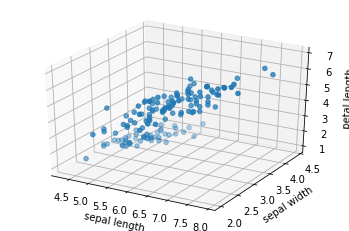

In [85]:
## 그래프 그리기
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure().gca(projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2])
ax.set_xlabel('sepal length')
ax.set_ylabel('sepal width')
ax.set_zlabel('petal length')
plt.show()

In [86]:
# numpy array >  RDD > DataFrame

In [87]:
_xRdd = spark.sparkContext.parallelize(data)
_xRdd.take(1)

[array([5.1, 3.5, 1.4, 0.2])]

In [88]:
#형변환
xRdd = _xRdd.map(lambda x: [float(i) for i in x])
xRdd.take(1)

[[5.1, 3.5, 1.4, 0.2]]

## k-means 모델링
mlib 라이브러리의 KMeans 모델
```python
KMeanstrain(rdd, k, maxIterations=100, initializationMode='k-means', seed=None, initializationSteps=2, epsilon=0.0001, initialModel=None)
```
- rdd: RDD 훈련데이터
- k: 클러스터 갯수
- maxIterations: 최대 반복 횟수(기본값:100)
- initializationMode: 초기 알고리즘 "random" 또는 "k-means"(기본값)
- seed: 무작위 seed 값(default=None)
- initializationSteps: k-means 단계수 (기본값:2)
- epsilon: 클러스터 중심값이 이 값이 이하로 움직이면 거리 임계값(기본값: 1e-4)
- initialModel: 초기 클러스터 중심값(기본값: None)

In [89]:
from pyspark.mllib.clustering import KMeans

model = KMeans.train(xRdd, k = 2, maxIterations = 10)

In [90]:
model.clusterCenters # 2개의 중심값들

[array([6.30103093, 2.88659794, 4.95876289, 1.69587629]),
 array([5.00566038, 3.36981132, 1.56037736, 0.29056604])]

In [91]:
#오류 계산
model.computeCost(xRdd)

152.34795176035803

In [92]:
#model.(tab) -> 어느 기능을 할지 확인

# Dataframe으로 k-Means 클러스터링

In [93]:
file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

데이터 육안으로 확인 후 가지고 오는것이 좋음. Tab으로 나누어졌을 수도 , 로 나누어졌을 수도

In [94]:
import pandas as pd

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

In [95]:
irisDf = spark.createDataFrame(iris)
irisDf.show()

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|
|         4.9|        3.1|         1.5|        0.1|Iris-setosa|
|         5.4|        3.7|         1.5|        0.2|Iris-setosa|
|         4.8|        3.4|         1.6|        0.2|Iris-setosa|
|         4.8|        3.0|         1.4| 

In [96]:
# 통계량 -> 확인해야됨 원래
irisDf.describe().show()
#count가 col별 동일한 값이 존재하지 않으면 NULL 값이 있다는 것임
#평균에 비해서 분산 값이 클 경우, 이상값이 있는것이 아닌지 확인
#평균+-표준편차

+-------+------------------+-------------------+------------------+------------------+--------------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|       species|
+-------+------------------+-------------------+------------------+------------------+--------------+
|  count|               150|                150|               150|               150|           150|
|   mean| 5.843333333333335| 3.0540000000000007|3.7586666666666693|1.1986666666666672|          null|
| stddev|0.8280661279778637|0.43359431136217375| 1.764420419952262|0.7631607417008414|          null|
|    min|               4.3|                2.0|               1.0|               0.1|   Iris-setosa|
|    max|               7.9|                4.4|               6.9|               2.5|Iris-virginica|
+-------+------------------+-------------------+------------------+------------------+--------------+



### features 생성
- Vector assembler는 변수를 묶어서 하나의 Vector로 만들어줌

In [97]:
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols=["sepal_length", "sepal_width", "petal_length", "petal_width"], outputCol="features")
xxDf = va.transform(irisDf)

In [98]:
xxDf.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)
 |-- features: vector (nullable = true)



In [99]:
xxDf.show(3)

+------------+-----------+------------+-----------+-----------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|    species|         features|
+------------+-----------+------------+-----------+-----------+-----------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|
+------------+-----------+------------+-----------+-----------+-----------------+
only showing top 3 rows



## 입력데이터에 명목 벡터가 있을 경우
```python
from pyspark.ml.feature import VectorIndexer

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="featuresIndexed",\
                               maxCategories=4).fit(xxDf)
xxxDf = featureIndexer.transform(xxDf)
```
사용

## k-means

In [100]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2) \
            .setFeaturesCol("features") \
            .setPredictionCol("cluster")

In [101]:
model = kmeans.fit(xxDf)
print(model.clusterCenters())

[array([6.30103093, 2.88659794, 4.95876289, 1.69587629]), array([5.00566038, 3.36037736, 1.56226415, 0.28867925])]


In [102]:
model.transform(xxDf).show()

+------------+-----------+------------+-----------+-----------+-----------------+-------+
|sepal_length|sepal_width|petal_length|petal_width|    species|         features|cluster|
+------------+-----------+------------+-----------+-----------+-----------------+-------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|      1|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|      1|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|      1|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|      1|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|      1|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|[5.4,3.9,1.7,0.4]|      1|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|[4.6,3.4,1.4,0.3]|      1|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|[5.0,3.4,1.5,0.2]|      1|
|         

# 최적의 클러스터 갯수 구하기
elbow, silhouette 그리고 gap statistic<br>
elbow 방법은 클러스터의 개수를 결정하는 직관적 방법 <br>
오류를 계산하고, 그래프를 그려서 클러스터 개수를 늘려도 그 오류의 기울기가 줄어드는 지점, 즉 추세가 꺽이는, 팔꿈치가 접히는 지점이 적당한 개수로 인식

### Silhouette
Silhouette은 계수로 클러스터링 적합도를 측정한다. 계수는 -1 ~ 1 값을 가진다.

- 1: 클러스터가 서로 잘 분리되어 있다는 의미
- 0: 클러스터가 서로 차이가 없다는 의미. 클러스터 간의 거리가 유의미하지 않다
- -1: 클러스터에 할당된 데이터가 올바르지 못하다는 의미.

In [104]:
from pyspark.ml.evaluation import ClusteringEvaluator
#silhouette = np.zeros(15)
silhouetteList = list()
for i in range(2, 17):
    # Trains a k-means model.
    kmeans = KMeans().setK(i).setFeaturesCol("features")
    model = kmeans.fit(xxDf)
    # Evaluate clustering by computing Within Set Sum of Squared Errors
    predictions = model.transform(xxDf)
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator().setMetricName("silhouette")
    silhouette = evaluator.evaluate(predictions)
    #silh_val.append(silhouette)
    print("...{} Within Set Sum of Squared Errors {}".format(i, silhouette))
    silhouetteList.append(silhouette)

...2 Within Set Sum of Squared Errors 0.8501515983265806
...3 Within Set Sum of Squared Errors 0.7342113066202725
...4 Within Set Sum of Squared Errors 0.6130741846319375
...5 Within Set Sum of Squared Errors 0.5922700623218558
...6 Within Set Sum of Squared Errors 0.4999912277884719
...7 Within Set Sum of Squared Errors 0.5361146249783653
...8 Within Set Sum of Squared Errors 0.4838981580337022
...9 Within Set Sum of Squared Errors 0.4627929703374237
...10 Within Set Sum of Squared Errors 0.49536104661594466
...11 Within Set Sum of Squared Errors 0.46626525790269313
...12 Within Set Sum of Squared Errors 0.4699133939964753
...13 Within Set Sum of Squared Errors 0.38288787905148153
...14 Within Set Sum of Squared Errors 0.43104469301902393
...15 Within Set Sum of Squared Errors 0.4446074243802379
...16 Within Set Sum of Squared Errors 0.457219525267984


## 클러스터 갯수에 따른 오류의 그래프

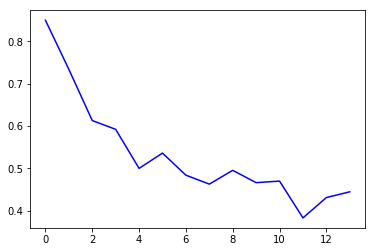

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.arange(14), silhouetteList[0:14], color='blue')